In [1]:
import os,sys
sys.path.append('/home/ahnsunghyun/pytorch/ganomaly')
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms.functional as F

이미지 관련 함수

In [108]:
# RGB로 구한 평균, 표준편차 -> BGR로 구한 평균, 표준편차
def cv2_infor(tmean,tstd):
    cmean,cstd=tmean.clone(),tstd.clone()
    cmean[0],cmean[2]=tmean[2],tmean[0]
    cstd[0],cstd[2]=tstd[2],tstd[0]

    return cmean,cstd

In [135]:
# 정규화된 텐서를 CV2 이미지로 변환
def tensor_to_cv_img(data, mean, std):
    # RGB mean, std -> BGR mean,std
    mean,std=cv2_infor(mean,std)
    MEAN, STD = mean.numpy(),std.numpy()

    # tensor to cv
    img = data # Tensor Shape. [C, H, W]
    img = img.detach().cpu().numpy() # tensor -> numpy
    img = np.transpose(img, (1, 2, 0)) # [C,H,W] -> [H,W,C]
    img = np.clip(255.0 * (img * STD + MEAN), 0, 255) # denomalize
    img = img.astype(np.uint8).copy() # np.float32 -> np.uint8

    return img

In [136]:
# tensor image -> plt show
def timshow(img):
    img=img.permute(1,2,0)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [64]:
# imshow function (cv2 image -> plt image -> plt.show)
# cv2 image를 plt image로 출력 
def imshow(in_img):
    out_img = cv2.cvtColor(in_img,cv2.COLOR_BGR2RGB) 
    plt.figure(figsize=(5,5))
    plt.imshow(out_img)
    plt.axis('off')
    plt.show()

데이터 확인

data/custom_helmet/train/0.normal/normal_tst_img_15076.png


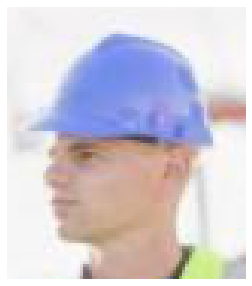

In [163]:
import random

dir=os.path.join('data','custom_helmet','train','0.normal')
pathlist=os.listdir(dir)
r=random.randint(0,len(pathlist))
rpath=dir+'/'+pathlist[r]
print(rpath)
img=cv2.imread(rpath,cv2.IMREAD_COLOR)
imshow(img)

데이터로더 제작

In [164]:
'''
= Dataloader Structure = 

dataloader={train, test}
dataloader['train']={(0:four_dim_tensor<images>, 1:one_dim_tensor<targets>), ....}
dataloader['test']={(0:four_dim_tensor<images>, 1:one_dim_tensor<targets>), ....}
'''

def make_loader(path):
    splits = ['train', 'test']
    transform = transforms.Compose([transforms.Resize((64,64)),
                                    transforms.ToTensor(),])

    dataset = {x: ImageFolder(os.path.join(path, x), transform) for x in splits}

    dataloader = {x: torch.utils.data.DataLoader(dataset=dataset[x], batch_size=64) for x in splits}
    return dataloader

In [165]:
'''
= Dataset Structure = 

Custom Dataset
├── test
│   ├── class0
│   │   └── 0.png
│   │   └── 1.png
│   │   ...
│   │   └── n.png
│   ├── class1
│   │   └── 0.png
│   │   └── 1.png
│   │   ...
│   │   └── n.png
├── train
│   ├── class0
│   │   └── 0.png
│   │   └── 1.png
│   │   ...
│   │   └── n.png
│   ├── class1
│   │   └── 0.png
│   │   └── 1.png
│   │   ...
│   │   └── n.png
'''

# image file path
dir='./data/custom_helmet'
dl=make_loader(path=dir)
print("len(dl['train']):",len(dl['train']))
print("len(dl['test']):",len(dl['test']))
print("len(dl['train'].dataset):",len(dl['train'].dataset))
print("len(dl['test'].dataset):",len(dl['test'].dataset))

len(dl['train']): 267
len(dl['test']): 60
len(dl['train'].dataset): 17069
len(dl['test'].dataset): 3794


데이터로더 확인

data[0].size(): torch.Size([64, 3, 64, 64])


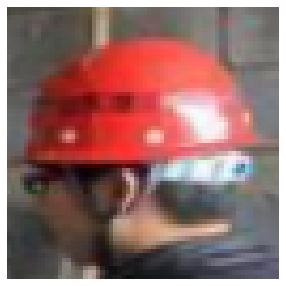

data[1].size(): torch.Size([64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [187]:
# check data
for data in dl['test']:
    print("data[0].size():",data[0].size())
    timshow(data[0][37])
    print("data[1].size():",data[1].size())
    print(data[1])
    break

평균, 표준편차 확인

In [188]:
mean = 0.
std = 0.
for data in dl['train']:
    data=data[0] # data[0] is four_dim_tensor<images> (64x3x64x64)
    batch_samples = data.size(0)
    images = data.view(batch_samples, data.size(1), -1) # 64 x 3 x 4096 // 4096 = 64*64
    mean += images.mean(2).sum(0) # calculate mean with 4096 data -> 64x3 data -> calcuate sum with 64 data -> 3 data
    std += images.std(2).sum(0) # 64x3 data -> 3 data

mean /= len(dl['train'].dataset)
std /= len(dl['train'].dataset)

print("data size:",len(dl['train'].dataset))
print("mean:",mean)
print("std:",std)

data size: 17069
mean: tensor([0.5718, 0.4870, 0.4388])
std: tensor([0.2163, 0.2131, 0.2123])


이미지 정규화

-- 원본 

In [194]:
npimg=np.array(img)
print(npimg)

[[[245 244 246]
  [245 244 246]
  [245 244 246]
  ...
  [243 243 243]
  [243 243 243]
  [243 243 243]]

 [[245 244 246]
  [245 244 246]
  [245 244 246]
  ...
  [243 243 243]
  [243 243 243]
  [243 243 243]]

 [[245 244 246]
  [245 244 246]
  [243 243 245]
  ...
  [243 243 243]
  [243 243 243]
  [243 243 243]]

 ...

 [[247 247 247]
  [247 247 247]
  [247 247 247]
  ...
  [210 197 195]
  [206 196 196]
  [201 197 196]]

 [[247 247 247]
  [247 247 247]
  [247 247 247]
  ...
  [209 194 192]
  [205 193 191]
  [198 194 193]]

 [[247 248 248]
  [249 247 247]
  [249 245 246]
  ...
  [212 188 193]
  [204 191 193]
  [188 197 194]]]


-- 정규화

In [196]:
cmean,cstd=cv2_infor(mean,std) # get BGR mean, std
tensor_img=F.to_tensor(npimg) # /255
tensor_img=F.normalize(tensor_img, cmean, cstd) # standarlization
print(tensor_img)

tensor([[[2.4583, 2.4583, 2.4583,  ..., 2.4213, 2.4213, 2.4213],
         [2.4583, 2.4583, 2.4583,  ..., 2.4213, 2.4213, 2.4213],
         [2.4583, 2.4583, 2.4213,  ..., 2.4213, 2.4213, 2.4213],
         ...,
         [2.4952, 2.4952, 2.4952,  ..., 1.8118, 1.7380, 1.6456],
         [2.4952, 2.4952, 2.4952,  ..., 1.7934, 1.7195, 1.5902],
         [2.4952, 2.5322, 2.5322,  ..., 1.8488, 1.7010, 1.4055]],

        [[2.2055, 2.2055, 2.2055,  ..., 2.1871, 2.1871, 2.1871],
         [2.2055, 2.2055, 2.2055,  ..., 2.1871, 2.1871, 2.1871],
         [2.2055, 2.2055, 2.1871,  ..., 2.1871, 2.1871, 2.1871],
         ...,
         [2.2607, 2.2607, 2.2607,  ..., 1.3404, 1.3220, 1.3404],
         [2.2607, 2.2607, 2.2607,  ..., 1.2852, 1.2668, 1.2852],
         [2.2791, 2.2607, 2.2239,  ..., 1.1747, 1.2299, 1.3404]],

        [[1.8161, 1.8161, 1.8161,  ..., 1.7617, 1.7617, 1.7617],
         [1.8161, 1.8161, 1.8161,  ..., 1.7617, 1.7617, 1.7617],
         [1.8161, 1.8161, 1.7979,  ..., 1.7617, 1.7617, 1.

이미지 정규화 해제

In [192]:
# tensor -> numpy
np_mean, np_std=cmean.numpy(),cstd.numpy()
dimg=tensor_img.detach().cpu().numpy() 

dimg = np.transpose(dimg, (1, 2, 0)) # [C,H,W] -> [H,W,C]
dimg=np.clip(255.0 * (dimg * np_std + np_mean), 0, 255) # denormalization
dimg = dimg.astype(np.uint8).copy() # np.float32 -> np.uint8
print(dimg)

[[[245 244 246]
  [245 244 246]
  [245 244 246]
  ...
  [243 243 243]
  [243 243 243]
  [243 243 243]]

 [[245 244 246]
  [245 244 246]
  [245 244 246]
  ...
  [243 243 243]
  [243 243 243]
  [243 243 243]]

 [[245 244 246]
  [245 244 246]
  [243 243 245]
  ...
  [243 243 243]
  [243 243 243]
  [243 243 243]]

 ...

 [[247 247 247]
  [247 247 247]
  [247 247 247]
  ...
  [210 197 195]
  [206 196 196]
  [201 197 196]]

 [[247 247 247]
  [247 247 247]
  [247 247 247]
  ...
  [209 194 192]
  [205 193 191]
  [198 194 193]]

 [[247 248 248]
  [249 247 247]
  [249 245 246]
  ...
  [212 188 193]
  [204 191 193]
  [188 197 194]]]


이미지 정규화 해제 및 출력

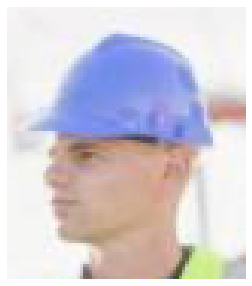

In [191]:
img=tensor_to_cv_img(tensor_img,mean,std) # normalized tensor image -> denormalized cv2 image
imshow(img) # cv2 image -> plt image -> show